In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
#to render in nbviewer, see https://nbviewer.org/github/jupyterhub/binder-billing/blob/master/analyze_data.ipynb?flush_cache=true

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.datasets import make_blobs
import math

In [ ]:
def create_iris_dataset(ndims):
    iris = datasets.load_iris()
    X = iris.data[:, :ndims]
    y = iris.target
    to_take_indices = list(set(np.arange(len(y)))-set(np.where(y==2)[0]))
    X = X[to_take_indices]
    y = y[to_take_indices]
    return X, y

# 2D

In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
X, y = create_iris_dataset(ndims=2)

#...different dataset (you may comment me out):
#X, y = make_blobs(n_samples=80, centers=2, random_state=6)

In [ ]:
def plot_all(X, model, title):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    fig, ax = plt.subplots(1,1)
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_title(title)
    plt.show()
    return ax.get_xlim(), ax.get_ylim()
    

def plot_all_2(X, model, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # plot support vectors
    if hasattr(model, "support_vectors_"):
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
    ax.set_title(title)
    plt.show()

In [ ]:
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
xlim, ylim = plot_all(X, model, title='LinearSVC (linear kernel)')
plot_all_2(X, model, title='LinearSVC (linear kernel)')

In [ ]:
model = svm.SVC(kernel='linear', C=1).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
xlim, ylim = plot_all(X, model, title='LinearSVC (linear kernel)')
plot_all_2(X, model, title='LinearSVC (linear kernel)')

In [ ]:
def abline(slope, intercept, xlim=(0,3), ylim=(0,3)):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    x_vals = np.array(axes.get_xlim())
    y_vals = -intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    

def find_seperatrix(model):
    W=model.coef_[0]
    I=model.intercept_
    a = -W[0]/W[1]
    b = I[0]/W[1]
    return a, b

slope, intercept = find_seperatrix(model)

print(slope, intercept)

abline(slope, intercept, xlim, ylim)

In [ ]:
x_vals = np.array(xlim)
y_vals = -intercept + slope * x_vals
points = [np.array(i) for i in zip(x_vals, y_vals)]

vector = points[1]-points[0]

print(points)
print(vector)

In [ ]:
def show_vectors(ax, vectors, vectors_with_start):
    """https://stackoverflow.com/a/42282532/5122790"""
    HEAD_SIZE = 0.2
    M = np.array(vectors)
    colors = ['r','g','b','k','gray']
    if vectors:
        for i,l in enumerate(range(0,M.shape[0])):
            ax.arrow(0,0,M[i,0],M[i,1],head_width=HEAD_SIZE,head_length=HEAD_SIZE,color = colors[i], length_includes_head=True)

    colors = ['c','m','y']
    if vectors_with_start:
        for i,(xs,ys,xf,yf) in enumerate([(*i[0],*i[1]) for i in vectors_with_start]):
            ax.arrow(xs,ys,xf,yf,head_width=HEAD_SIZE,head_length=HEAD_SIZE,color = colors[i], length_includes_head=True)

    return ax

In [ ]:
def ortho_proj(a,b):
    #https://en.wikipedia.org/wiki/Vector_projection
    a1_sc = np.dot(a,(b/np.linalg.norm(b)))
    b_hat = b/np.linalg.norm(b)
    a1 = a1_sc*b_hat
    a2 = a-a1
    return a2

In [ ]:
center_point = points[0]+0.5*vector

In [ ]:
print(ortho_proj(vector, center_point))

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
show_vectors(ax, [], [(points[0], vector), (center_point, ortho_proj(vector, center_point))])

ax.plot(*center_point,'ok') 
ax.set_aspect('equal', 'box')
plt.grid(b=True, which='major')

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [ ]:
print(model.coef_[0])
print(center_point+model.coef_[0])

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
show_vectors(ax, [], [(points[0], vector), (center_point, ortho_proj(vector, center_point)), (center_point, model.coef_[0])])

ax.plot(*center_point,'ok') 
ax.set_aspect('equal', 'box')
plt.grid(b=True, which='major')

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# 3D

In [ ]:
#https://stackoverflow.com/a/51301399/5122790, https://stackoverflow.com/a/69407977/5122790 !!!
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from dataclasses import dataclass

In [ ]:
X, y = create_iris_dataset(ndims=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], color=["r" if i==0 else "b" for i in y])
plt.show()

In [ ]:
def make_meshgrid(X=None, minx=None, miny=None, maxx=None, maxy=None, size=None, amount=30, margin=0):
    assert X is not None or (minx is not None and miny is not None and maxx is not None and maxy is not None) or size is not None
    if X is not None:
        minx = min(X[:,0]) if minx is None or min(X[:,0])<minx else minx
        miny = min(X[:,1]) if miny is None or min(X[:,1])<miny else miny
        maxx = max(X[:,0]) if maxx is None or max(X[:,0])>maxx else maxx
        maxy = max(X[:,1]) if maxy is None or max(X[:,1])>maxy else maxy
    elif size is not None and (minx is None and miny is None and maxx is None and maxy is None):
        minx = miny = -size
        maxx = maxy = size
    lsx = np.linspace(minx-margin, maxx+margin, amount)
    lsy = np.linspace(miny-margin, maxy+margin, amount)
    xx, yy = np.meshgrid(lsx,lsy)
    return xx, yy


def plot_3d_boundary(clf):
    # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
    # Solve for w3 (z)
    z = lambda clf, x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]
    # https://stackoverflow.com/a/51301399/5122790 !!!

    xx, yy = make_meshgrid(X)

    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot3D(X[y==0,0], X[y==0,1], X[y==0,2],'ob')
    ax.plot3D(X[y==1,0], X[y==1,1], X[y==1,2],'sr')
    ax.plot_surface(xx, yy, z(clf,xx,yy))
    ax.view_init(30, 60)
    plt.show()
    
plot_3d_boundary(model)

In [ ]:
def ortho_projection_affine(a, b):
    """https://en.wikipedia.org/wiki/Vector_projection"""
    return np.dot(np.dot(a,b)/np.dot(b,b),b)

class ThreeDFigure():
    def __init__(self, trafo_fn=None, back_trafo_fn=None, swap_axes=None):
        self.trafo_fn = trafo_fn if trafo_fn is not None else lambda x: x
        self.back_trafo_fn = back_trafo_fn if back_trafo_fn is not None else lambda x: x
        self.swap_axes = swap_axes
        #https://community.plotly.com/t/creating-a-3d-scatterplot-with-equal-scale-along-all-axes/15108/7
        self.fig = go.Figure(layout=go.Layout(
                        scene=dict(camera=dict(eye=dict(x=1, y=1, z=1)), aspectmode="data"),
                        autosize=True,
                        width=1000,
                        height=800,
                        margin=dict(l=10, r=10, b=10, t=10, pad=4),
                        paper_bgcolor="White"))
        
    def _transform(self, points, inverse=False):
        trafo_fn = self.back_trafo_fn if inverse else self.trafo_fn              
        points = np.array([trafo_fn(point) for point in points])    
        if self.swap_axes:
            points = self._swap_axes(points, self.swap_axes)
        return points
    
    def _swap_axes(self, points, swap_axes):
        swap_translate = {"x": 0, "y": 1, "z": 2}
        ind1, ind2 = swap_translate[swap_axes[0]], swap_translate[swap_axes[1]]
        tmp = points[:,ind1].copy()
        points[:,ind1] = points[:,ind2]
        points[:,ind2] = tmp
        return points
    
                    
    def add_surface(self, xx, yy, z_func, swap_axes=None, opacity=None):
        xy_arr = np.vstack([xx.flatten(), yy.flatten()]).T
        z_arr = np.array([z_func(*i) for i in xy_arr])
        points = np.column_stack([xy_arr, z_arr])
        points = self._transform(points)
        if swap_axes: 
            points = self._swap_axes(points, swap_axes)
        surface_form = lambda x: x.reshape(round(math.sqrt(x.shape[0])),-1)
        self.fig.add_trace(go.Surface(x=surface_form(points[:,0]), y=surface_form(points[:,1]), z=surface_form(points[:,2]), opacity=opacity, showlegend=False, showscale=False))
    
    
    def add_line(self, point1, point2, width=6, do_transform=True, name=None, **kwargs):
        if do_transform:
            point1 = self._transform(np.array([point1])).squeeze()
            point2 = self._transform(np.array([point2])).squeeze()
        self.fig.add_trace(
            go.Scatter3d(x = [point1[0], point2[0]],
                         y = [point1[1], point2[1]],
                         z = [point1[2], point2[2]],
                         marker = dict(size = 1),
                         line = dict(width = width),
                         name=name,
                         **kwargs
                         )
        )
        
    def add_markers(self, points, color="black", size=2, name=None, **kwargs):
        points = np.array(points)
        if points.ndim == 1: points = np.array([points])
        points = self._transform(points)
        default_args = dict(mode="markers", x=points[:,0], y=points[:,1], z=points[:,2], marker={"color": color, "size": size, "line": {"width": 0}}, name=name)
        self.fig.add_trace(go.Scatter3d(**{**default_args, **kwargs}))
        
    
    def add_sample_projections(self, X, onto, n_samples=10, **kwargs):
        show_vecs = X[np.random.choice(X.shape[0], n_samples, replace=False), :]
        for point in show_vecs:
            proj = ortho_projection_affine(point, onto)
            self.add_line(point, proj, **kwargs)
            
    
    def __enter__(self, *args):
        return self
    
    def __exit__(self, exc_type, exc, exc_tb):
        if not exc_type:
            display(self.fig)
    

In [ ]:
@dataclass
class Plane:
    a: float
    b: float
    c: float
    d: float
    
    @property
    def normal(self):
        return np.array([self.a, self.b, self.c])
    
    def __contains__(self, point:np.array):
        return np.isclose(self.a*point[0] + self.b*point[1] + self.c*point[2] + self.d, 0)
    
    def project(self, point):
        x,y,z = point
        k = (self.a*x + self.b*y + self.c*z + self.d)/(self.a**2 + self.b**2 + self.c**2)
        return np.array([x - k*self.a, y-k*self.b, z-k*self.c])
   
    def z(self, x, y):
        return (- self.d - self.b*y - self.a*x)/self.c

In [ ]:
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

with ThreeDFigure() as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(X, margin=1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line(X.mean(axis=0)-decision_plane.normal, X.mean(axis=0)+decision_plane.normal) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center
    
    fig.add_line(-decision_plane.normal*5, decision_plane.normal*5) #orthogonal of decision hyperplane through [0,0,0]
    fig.add_sample_projections(X, decision_plane.normal) #orthogonal lines from the samples onto the decision hyperplane orthogonal

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=6, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

with ThreeDFigure() as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(X, margin=1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line(X.mean(axis=0)-decision_plane.normal, X.mean(axis=0)+decision_plane.normal) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center
    
    fig.add_line(-decision_plane.normal*5, decision_plane.normal*5) #orthogonal of decision hyperplane through [0,0,0]
    fig.add_sample_projections(X, decision_plane.normal) #orthogonal lines from the samples onto the decision hyperplane orthogonal

* I'm having so many apparently hard-to-solve problems - the decision-boundary for example goes from (minx,miny) to (maxx,maxy), with the corresponding z-coordinate. However that's superflous, it may become waaay to big there, because the original x/y/z coordinate system is irrelevant! The size of the decision surface is constrained instead rather by the circle of all lines that go through a point and in parallel to the orthogonal of the decision surface. But to figure out the size of the decision boundary from that is far from trivial - again because I always need the translation from the irrelevant acutal xyz-coordinate system to the coordinate system which is relevant for me, which is one in which the decision surface has two coordinate values equal to zero. If I do that, every other calculation becomes trivial!!
* Same holds for the problem "how long should the decisionsurface-orthogonal be" - calculating it now is hard, but once we have translated the coordinate system it's just the min/max z-coordinate!

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=6, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])


with ThreeDFigure() as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(X, margin=1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line([0,0,0], decision_plane.normal*100) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center
    
    for point, side in zip(X, y):
        fig.add_line(point, point-decision_plane.normal*100 if side else point+decision_plane.normal*100)


In [ ]:
def normalize(vec):
    return vec/np.linalg.norm(vec)

In [ ]:
decision_plane = Plane(*model.coef_[0], model.intercept_[0])
vec = normalize(decision_plane.normal)
print("Original Vec:", vec)

with ThreeDFigure() as fig:
    #coordinate system
    fig.add_surface(*make_meshgrid(size=1), lambda _,__: 0, opacity=0.3)
    fig.add_surface(*make_meshgrid(size=1), lambda _,__: 0, swap_axes="xz", opacity=0.3)
    fig.add_surface(*make_meshgrid(size=1), lambda _,__: 0, swap_axes="yz", opacity=0.3)    
    fig.add_line([-1,0,0], [1,0,0])
    fig.add_line([0,-1,0], [0,1,0])
    fig.add_line([0,0,-1], [0,0,1])
    
    #vec and its projections
    fig.add_line([0,0,0], vec, width=12)
    fig.add_line([0,0,0], [0, vec[1], vec[2]])
    fig.add_line([0,0,0], [vec[0], 0, vec[2]])
    fig.add_line([0,0,0], [vec[0], vec[1], 0])


In [ ]:
def make_base_changer(plane):
    uvec1 = plane.normal
    uvec2 = [0, -plane.d/plane.b, plane.d/plane.c] #NOT [1, 0, plane.z(model, 1, 0)] !!
    uvec3 = np.cross(uvec1, uvec2)
    transition_matrix = np.linalg.inv(np.array([uvec1, uvec2, uvec3]).T)
    
    origin = np.array([0,0,0])
    new_origin = plane.project(origin)
    forward  = lambda point: transition_matrix.dot(point - new_origin)
    backward = lambda point: np.linalg.inv(transition_matrix).dot(point) + new_origin
    return forward, backward


#wir haben im 3D einen Degree of freedom hier!! uvec1 ist eindeutig definiert, aber uvec2 und uvec3 haben nur
#die Bedingung dass sie orthogonal zueinander und zu uvec1 sind - das ist 1 dof. Im 2D haben wir 0 dof, da die 
#decisionboundary 1dimensional ist und ihre orthogonale auch. Wie viele dof haben wir im höherdim? immer n_dim-2? 
#das hat ja mega auswirkungen auf was ich machen will, am besten wäre es die neuen basen so zu wählen dass die
#jeweils nächsten auch wieder orthogonal sind...!

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=6, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

trafo, back_trafo = make_base_changer(decision_plane)

with ThreeDFigure(trafo, back_trafo, swap_axes="xz") as fig:
    fig.add_markers(X, color=y) #samples
    xx, yy = make_meshgrid(minx=-0.7, miny=-10, maxx=0.01, maxy=1, margin=1) #manual values!
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line([0,0,0], decision_plane.normal*100) #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3) #coordinate center
    fig.add_sample_projections(X, decision_plane.normal) #orthogonal lines from the samples onto the decision hyperplane orthogonal
    
    for point, side in zip(X, y):
        #fig.add_line(point, point-decision_plane.normal*100 if side else point+decision_plane.normal*100)
        #that ^ would be the blunt way to do it, smarter is to set transform, set x=0, backtransform
        transformed = trafo(point)
        onto_plane = back_trafo([0, transformed[1], transformed[2]])
        fig.add_line(point, onto_plane)
        
#find a way to pre-determine the minx, miny, ... of the meshgrid THROUGH THE TRANSLATION

In [ ]:
# the way how to determine the minx/miny/.. of the meshgrid:


onto_plane = np.array([back_trafo([0, trafo(point)[1], trafo(point)[2]]) for point, side in zip(X, y)])
minx, miny = onto_plane.min(axis=0)[:2]
maxx, maxy = onto_plane.max(axis=0)[:2]
    
        
with ThreeDFigure() as fig: #trafo, back_trafo, swap_axes="xz"
    fig.add_markers(X, color=y, showlegend=False) #samples
    xx, yy = make_meshgrid(minx=minx, miny=miny, maxx=maxx, maxy=maxy, margin=0.1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_line([0,0,0], decision_plane.normal*100, name="normal_meanpoints") #orthogonal of decision hyperplane through mean of points
    fig.add_markers([0,0,0], size=3, name="origin") #coordinate center
    fig.add_sample_projections(X, decision_plane.normal, showlegend=False) #orthogonal lines from the samples onto the decision hyperplane orthogonal
    
    for point, side in zip(X, y):
        fig.add_line(point, back_trafo([0, trafo(point)[1], trafo(point)[2]]), showlegend=False)

## New stuff

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=2, n_features=3)
model = svm.LinearSVC(C=1, max_iter=10000).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

trafo, back_trafo = make_base_changer(decision_plane)

onto_plane = np.array([back_trafo([0, trafo(point)[1], trafo(point)[2]]) for point, side in zip(X, y)])
minx, miny = onto_plane.min(axis=0)[:2]
maxx, maxy = onto_plane.max(axis=0)[:2]

z_vals = [trafo(point)[0] for point in X]
minneg, maxneg = min(z_vals), max([i for i in z_vals if i < 0])
minpos, maxpos = min([i for i in z_vals if i > 0]), max(z_vals)

In [ ]:
#instead of taking the transform, we could also just take the z-component (or the length, as x&y of it are 0) of the vector from a point to its projection

for point, val in zip(X, y):
    transformed_proj = np.around(trafo(decision_plane.project(point)-point), 5)
    assert transformed_proj[1] == transformed_proj[2] == 0
    assert (np.sign(transformed_proj[0]) == 1) == (val == 0)
    
assert all(np.array([trafo(point)[0] for point in X]).argsort() == np.array([(decision_plane.project(point)-point)[2] for point in X]).argsort())

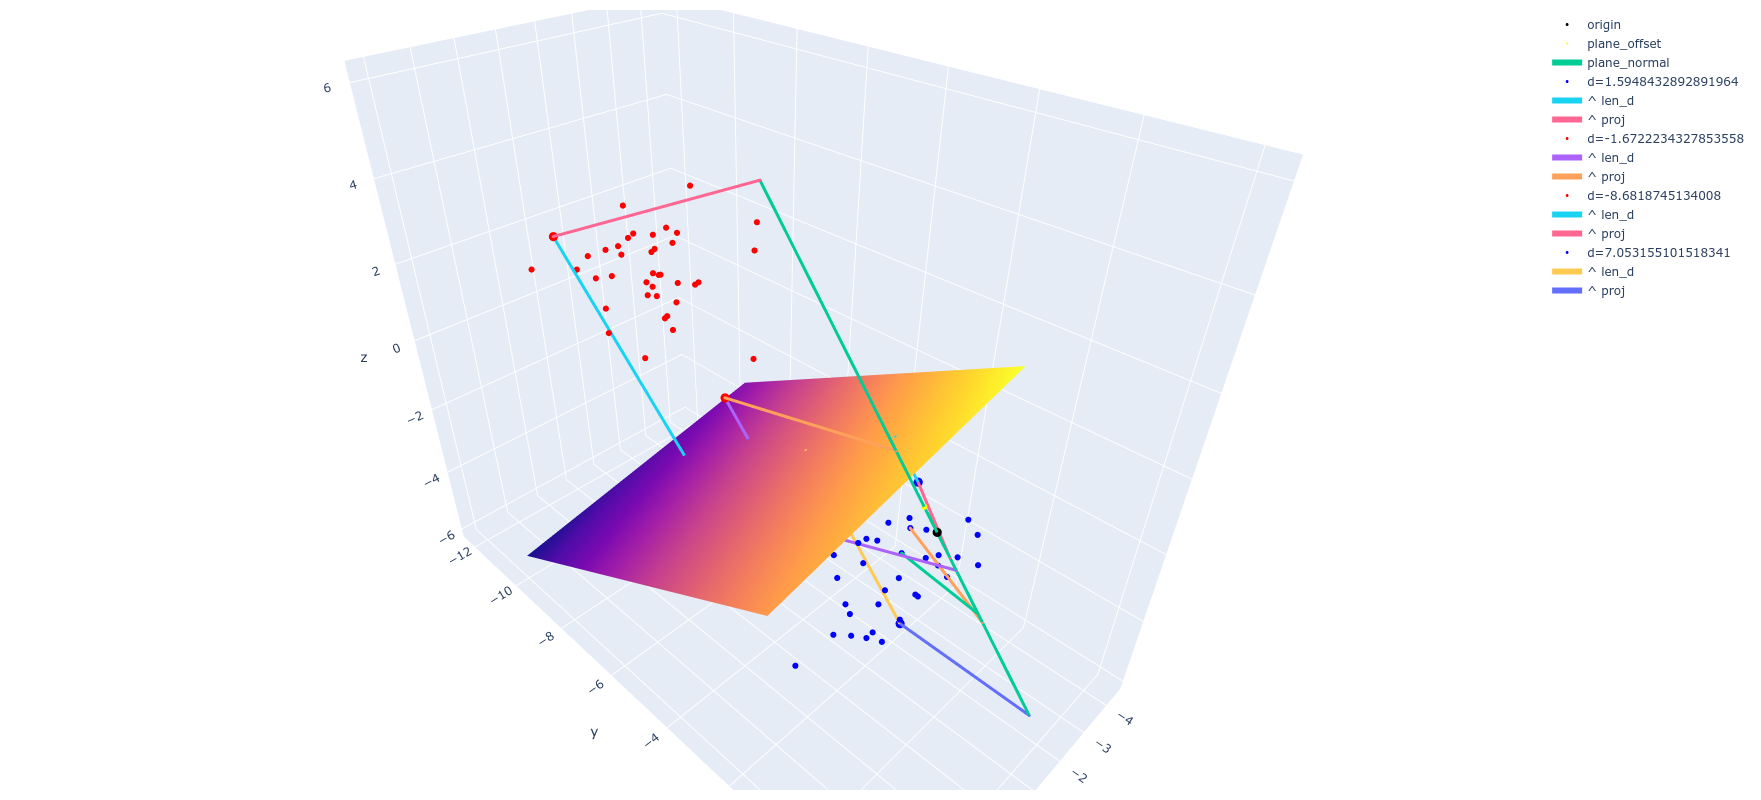

In [ ]:
with ThreeDFigure() as fig: #trafo, back_trafo, swap_axes="xz"
    plane_offset = decision_plane.project([0,0,0]) #point where plane == plane.normal (plane doesn't need to go through [0,0,0])
    fig.add_markers([0,0,0], size=3, name="origin") #coordinate center
    fig.add_markers(plane_offset, name="plane_offset", color="yellow")
    fig.add_line(plane_offset+decision_plane.normal*minneg, plane_offset+decision_plane.normal*maxpos, name="plane_normal") 
    for point, side in zip(X, y):
        if trafo(point)[0] in [minneg, maxneg, minpos, maxpos]:
            fig.add_markers(point, color="blue" if side else "red", name="d="+str(trafo(point)[0]), size=3)
            fig.add_line(point, back_trafo([0, trafo(point)[1], trafo(point)[2]]), name="^ len_d",)            
            fig.add_line(point, ortho_projection_affine(point, decision_plane.normal), name="^ proj")
        else:
            fig.add_markers(point, color="blue" if side else "red", name=str(trafo(point)[0]), showlegend=False)
    xx, yy = make_meshgrid(minx=minx, miny=miny, maxx=maxx, maxy=maxy, margin=0.1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_sample_projections(X, decision_plane.normal, n_samples=3, showlegend=False)

In [ ]:
with ThreeDFigure(trafo, back_trafo, swap_axes="xz") as fig:
    fig.add_markers([0,0,0], size=3, name="origin (original space)") #coordinate center
    fig.add_markers(back_trafo([0,0,0]), size=3, name="origin (new space)") #coordinate center
    plane_offset = decision_plane.project([0,0,0]) #point where plane == plane.normal
    fig.add_markers(plane_offset, name="plane_offset", color="yellow")
    fig.add_line(plane_offset+decision_plane.normal*minneg, plane_offset+decision_plane.normal*maxpos, name="plane_normal") 
    for point, side in zip(X, y):
        if trafo(point)[0] in [minneg, maxneg, minpos, maxpos]:
            fig.add_markers(point, color="blue" if side else "red", name="d="+str(trafo(point)[0]), size=3)
            fig.add_line(point, back_trafo([0, trafo(point)[1], trafo(point)[2]]), name="^ len_d",)            
            fig.add_line(point, ortho_projection_affine(point, decision_plane.normal), name="^ proj")
        else:
            fig.add_markers(point, color="blue" if side else "red", name=str(trafo(point)[0]), showlegend=False)
    xx, yy = make_meshgrid(minx=minx, miny=miny, maxx=maxx, maxy=maxy, margin=0.1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_sample_projections(X, decision_plane.normal, n_samples=3, showlegend=False)

## include support-vectors in drawing (taking other SVM class!)

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=6, n_features=3)
model = svm.SVC(kernel='linear', C=1).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)
decision_plane = Plane(*model.coef_[0], model.intercept_[0])

trafo, back_trafo = make_base_changer(decision_plane)

onto_plane = np.array([back_trafo([0, trafo(point)[1], trafo(point)[2]]) for point, side in zip(X, y)])
minx, miny = onto_plane.min(axis=0)[:2]
maxx, maxy = onto_plane.max(axis=0)[:2]

z_vals = [trafo(point)[0] for point in X]
minneg, maxneg = min(z_vals), max([i for i in z_vals if i < 0])
minpos, maxpos = min([i for i in z_vals if i > 0]), max(z_vals)


with ThreeDFigure() as fig: #trafo, back_trafo, swap_axes="xz":
    fig.add_markers([0,0,0], size=3, name="origin (original space)") #coordinate center
    plane_offset = decision_plane.project([0,0,0]) #point where plane == plane.normal
    fig.add_markers(plane_offset, name="plane_offset", color="yellow")
    fig.add_line(plane_offset+decision_plane.normal*minneg, plane_offset+decision_plane.normal*maxpos, name="plane_normal") 
    for point, side in zip(X, y):
        if trafo(point)[0] in [minneg, maxneg, minpos, maxpos]:
            fig.add_markers(point, color="blue" if side else "red", name="d="+str(trafo(point)[0]), size=3)
            fig.add_line(point, back_trafo([0, trafo(point)[1], trafo(point)[2]]), name="^ len_d",)            
            fig.add_line(point, ortho_projection_affine(point, decision_plane.normal), name="^ proj")
        else:
            fig.add_markers(point, color="blue" if side else "red", name=str(trafo(point)[0]), showlegend=False)
    xx, yy = make_meshgrid(minx=minx, miny=miny, maxx=maxx, maxy=maxy, margin=0.1)
    fig.add_surface(xx, yy, decision_plane.z) #decision hyperplane
    fig.add_markers([0,0,0], size=3, name="origin") #coordinate center
    fig.add_sample_projections(X, decision_plane.normal, n_samples=3, showlegend=False)
    
    #if hasattr(model, "support_vectors_"):
    for n, point in enumerate(model.support_vectors_):
        fig.add_markers(point, name=f"support_vec_{n}", marker={"color": None, "size": 2, "line": {"width": 3, "color": "black"}},)

# Checking projection-methods & distance measures from point to projection

In [ ]:
X, y = make_blobs(n_samples=80, centers=2, random_state=6, n_features=3)
model = svm.SVC(kernel='linear', C=1).fit(X, y)
print("Coefficients:", model.coef_, "Intercept:", model.intercept_)

decision_plane = Plane(*model.coef_[0], model.intercept_[0])
forward, backward = make_base_changer(decision_plane)

list(zip(y, X))[:10]

In [ ]:
# helper functions
def get_normalized_fn(orig_fn, all_mds, *more_args):
    fmin, fmax = min(all_vals := [orig_fn(all_mds[i], *more_args) for i in range(len(all_mds))]), max(all_vals)
    return lambda x: round(((orig_fn(x, *more_args)-fmin)/(fmax-fmin))*100, 2)

get_both = lambda fn, all_mds, *more_args: (fn, get_normalized_fn(fn, all_mds, *more_args))

vec_dist = lambda a, b: np.linalg.norm(a-b)

### Now let's get to the actual projections/distances...

In [ ]:
prototypicality_pre, prototypicality = get_both(lambda x, forwardproj: abs(forwardproj(x)[0]), X, forward)

project_pre, project = get_both(lambda x, plane: vec_dist(plane.project(x), x), X, decision_plane)

#see https://stackoverflow.com/a/17661431: distance = n * p + d
project2_pre = lambda x, plane: np.dot(plane.normal, x) + plane.d  #This, nicely, returns 0 if on plane, something > 0 if in FRONT (side of normal) and something < 0 if BEHIND of plane.
abs_project2_pre, abs_project2 = get_both(lambda x, plane: abs(np.dot(plane.normal, x) + plane.d), X, decision_plane)

In [ ]:
#onto_plane =  p' = p - (n ⋅ p + d) * n  -- see https://stackoverflow.com/a/41897378

quotients = [abs_project2_pre(x, decision_plane)/prototypicality_pre(x, forward) for x in X[:20]]
assert np.isclose(min(quotients), max(quotients))
#TODO figure out WHY the quotient between protypicality, proj-dist and abs-proj-dist-2 is the way it is and then correct this!!

def onto_plane(x, plane, quotient):
    #plane_dist = project2_pre(x, plane)
    #plane_dist = project_pre(x, plane)
    #plane_dist = prototypicality_pre(x, forwardproj) #hiermit klappts..
    plane_dist = project2_pre(x, plane) / quotient
    #TODO figure out WHY the quotient between protypicality, proj-dist and abs-proj-dist-2 is the way it is and then correct this!!
    return x - plane_dist * plane.normal

project3_pre, project3 = get_both(lambda x, plane, quotient: vec_dist(onto_plane(x, plane, quotient), x), X, decision_plane, quotients[0])

In [ ]:
project_using_basechanger = lambda x, forwardproj, backwardproj: backwardproj([0, (transformed := forwardproj(x))[1], transformed[2]])
project_using_project     = lambda x, plane: plane.project(x)
project_using_project2_3  = lambda x, plane, quotient: onto_plane(x, plane, quotient)

In [ ]:
for x in X[:10]:
    print("Point:", x, "  reversed:", project2_pre(x, decision_plane) > 0)
    #print("Forward-x:", forward(x))

    print("  Normed Project:", project(x))
    print("  Normed Prototypicality:", prototypicality(x))
    print("  Normed abs projection Distance:", abs_project2(x))
    print("  Normed Distance Point & Projection3:", project3(x))
    print()

    print("  Unnormed Project:", project_pre(x, decision_plane))
    print("  Unnormed Prototypicality:", prototypicality_pre(x, forward))
    print("  Projection Distance:", project2_pre(x, decision_plane))
    print("  Abs projection Distance:", abs_project2_pre(x, decision_plane))
    print("  Unnormed Distance Point <-> Projection3", project3_pre(x, decision_plane, quotients[0]))
    print()

    print("  Quotient Prototypicality <-> Proj Dist:", project_pre(x, decision_plane)/prototypicality_pre(x, forward))
    print("  Quotient Prototypicality <-> Abs Proj Dist 2:", abs_project2_pre(x, decision_plane)/prototypicality_pre(x, forward))
    print("  Proj Dist <-> Abs Proj Dist 2:", project_pre(x, decision_plane)/abs_project2_pre(x, decision_plane))
    #TODO figure out WHY the quotient between protypicality, proj-dist and abs-proj-dist-2 is the way it is.
    print()

    print("  Projections are actually on the plane: ", project_using_basechanger(x, forward, backward) in decision_plane, project_using_project(x, decision_plane) in decision_plane, project_using_project2_3(x, decision_plane, quotients[0]) in decision_plane)
    print("\n")

In [ ]:
#deleteme from here

In [ ]:
def plane_proj(plane, point):
    x, y, z = point
    k = (plane.a * x + plane.b * y + plane.c * z + plane.d) / (plane.a ** 2 + plane.b ** 2 + plane.c ** 2)
    k = 2*k
    return np.array([x - k * plane.a, y - k * plane.b, z - k * plane.c])


for x in X[:5]:
    tmpproj = plane_proj(decision_plane, x)
    print(vec_dist(x, tmpproj))
    print(vec_dist(x, decision_plane.project(x)))
    print()

In [ ]:
def plane_proj(plane, point):
    x, y, z = point
    k = (plane.a * x + plane.b * y + plane.c * z + plane.d) / (plane.a ** 2 + plane.b ** 2 + plane.c ** 2)
    return np.array([x - k * plane.a, y - k * plane.b, z - k * plane.c])


for x in X[:5]:
    tmpproj = plane_proj(decision_plane, x)
    print(vec_dist(x, tmpproj))
    print(vec_dist(x, decision_plane.project(x)))
    print()

In [ ]:
project_using_basechanger = lambda x, forwardproj, backwardproj: backwardproj([0, (transformed := forwardproj(x))[1], transformed[2]])
project_using_project     = lambda x, plane: plane.project(x)
project_using_project2_3  = lambda x, plane, quotient: onto_plane(x, plane, quotient)

In [ ]:
for x in X[:5]:
    print(decision_plane.project(x), decision_plane.project(x) in decision_plane, vec_dist(decision_plane.project(x), x))
    
    tmp = np.dot(decision_plane.normal, x) + decision_plane.d 
    tmp = tmp/(decision_plane.a**2+decision_plane.b**2+decision_plane.c**2)
    proj = x - tmp * decision_plane.normal
    print(proj)
    
    
    print()

In [ ]:
#deleteme until here